In [1]:
# This nodebook measures the daily APY for all the curve pools in curve_requests/main.json
# It then plots the 30 day APY of the top 10 pools, in terms of avg APY over the period.
# Option to only process pools involving specific tokens.

import json
import os
import time
import matplotlib.pyplot as plt
from web3 import Web3, HTTPProvider
from datetime import datetime, timedelta
import json

In [2]:
# Load the list of pools
target_tokens = []
# target_tokens = [
#   "0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48", # USDC
#   "0x6B175474E89094C44Da98b954EedeAC495271d0F", # DAI
#   "0xdAC17F958D2ee523a2206206994597C13D831ec7", # USDT
# ]
# Alias addresse for native token
native_alias = "0xEeeeeEeeeEeEeeEeEeEeeEEEeeeeEeeeeeeeEEeE"

# Contains every piece of data needed
with open('curve_requests/main.json') as f:
    pool_data = json.load(f)["data"]["poolData"]

# Filter out pools that don't involve the target token
if len(target_tokens) > 0:
    target_tokens = [token.lower() for token in target_tokens]
    temp_pool_data = []
    for pool in pool_data:
        for token in pool["coins"]:
            if token["address"].lower() in target_tokens:
                temp_pool_data.append(pool)
                break

    pool_data = temp_pool_data
else:
    # Store the list of tokens in target_tokens if none were specified
    target_tokens_set = set()
    for pool in pool_data:
        for token in pool["coins"]:
            if token["address"].lower() not in target_tokens:
                target_tokens_set.add(token["address"].lower())
    target_tokens = list(target_tokens_set)
print(f"{len(target_tokens)} different tokens involved in pools")

pool_addresses = [pool["address"] for pool in pool_data]
pool_dict = {pool["address"]: pool for pool in pool_data}
print(f"Loaded {len(pool_addresses)} pools")

66 different tokens involved in pools
Loaded 49 pools


In [3]:
# Setup function for grabbing APY data

# Provider setup
infura_url = os.getenv('NODE_URL_ETH')
w3 = Web3(HTTPProvider(infura_url))

# Reuse ABI of 3pool (might cause issues, pools have differences)
with open('./curve_pools/abi/3pool.abi.json', 'r') as f:
    contract_abi = json.load(f)

def get_pool_apys(provider, pool_addr, current_block, days):
    contract = provider.eth.contract(address=pool_addr, abi=contract_abi)
    blocks = [current_block - (i * 60 * 60 * 24 // 12) for i in range(days)]
    virtual_prices = []
    for block in blocks:
        try:
            virtual_price = contract.functions.get_virtual_price().call(block_identifier=block)
            virtual_prices.append(virtual_price)
        except Exception as e:
            print(f"Error at block {block}: {e}")

    # Calculate APY
    apys = []
    for i in range(len(virtual_prices) - 1):
        apy = (virtual_prices[i] / virtual_prices[i + 1]) ** 365 - 1
        apy *= 100
        apys.append(apy)

    return apys


In [4]:
# Pull data for all the pools

DAYS = 30
current_block = w3.eth.block_number
current_timestamp = time.time()
apy_dict = {}

# Start pulling data
for pool_addr in pool_addresses:
    sym = ""
    if "symbol" in pool_dict[pool_addr]:
        sym = pool_dict[pool_addr]["symbol"]
    print(f"Fetching APY data for {sym} {pool_addr[:8]}...")
    apys = get_pool_apys(w3, pool_addr, current_block, DAYS)
    apy_dict[pool_addr] = apys

print("Done fetching data.")

Fetching APY data for 3Crv 0xbEbc44...
Fetching APY data for a3CRV 0xDeBF20...
Fetching APY data for ankrCRV 0xA96A65...
Fetching APY data for yDAI+yUSDC+yUSDT+yBUSD 0x79a8C4...
Fetching APY data for cDAI+cUSDC 0xA2B47E...
Fetching APY data for eursCRV 0x0Ce6a5...
Fetching APY data for hCRV 0x4CA9b3...
Fetching APY data for ib3CRV 0x2dded6...
Fetching APY data for linkCRV 0xF178C0...
Fetching APY data for ypaxCrv 0x06364f...
Fetching APY data for crvRenWBTC 0x930541...
Fetching APY data for saCRV 0xEB16Ae...
Fetching APY data for crvRenWSBTC 0x7fC77b...
Fetching APY data for eCRV 0xc5424B...
Fetching APY data for steCRV 0xDC2431...
Fetching APY data for crvPlain3andSUSD 0xA5407e...
Fetching APY data for cDAI+cUSDC+USDT 0x52EA46...
Fetching APY data for yDAI+yUSDC+yUSDT+yTUSD 0x45F783...
Fetching APY data for dusd3CRV 0x8038C0...
Fetching APY data for gusd3CRV 0x4f0626...
Fetching APY data for husd3CRV 0x3eF6A0...
Fetching APY data for LinkUSD3CRV 0xE7a24E...
Fetching APY data for musd3

avg APY: 9.70% for RAI3CRV 0x618788... 
avg APY: 7.64% for ib3CRV 0x2dded6... 
avg APY: 4.58% for a3CRV 0xDeBF20... 
avg APY: 3.02% for cDAI+cUSDC 0xA2B47E... 
avg APY: 2.41% for yDAI+yUSDC+yUSDT+yTUSD 0x45F783... 
avg APY: 2.23% for saCRV 0xEB16Ae... 
avg APY: 2.13% for cDAI+cUSDC+USDT 0x52EA46... 
avg APY: 2.08% for  0xBfAb6F... 
avg APY: 1.86% for steCRV 0xDC2431... 
avg APY: 1.81% for ankrCRV 0xA96A65... 


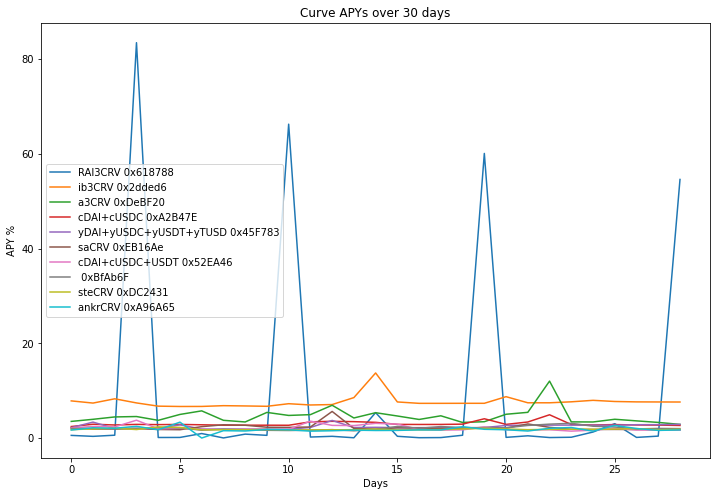

In [5]:
# Compute avg APY for each pool, sorted

apylist = []
for pool_addr in pool_addresses:
    apys = apy_dict[pool_addr]
    avg_apy = sum(apys) / len(apys)
    apylist.append((avg_apy, pool_addr))

apylist.sort(reverse=True)

# Plot the top 10 pools, on the same graph
TOP = 10
plt.figure(figsize=(12, 8))
for i in range(min(TOP, len(apylist))):
    avg_apy, pool_addr = apylist[i]
    sym = ""
    if "symbol" in pool_dict[pool_addr]:
        sym = pool_dict[pool_addr]["symbol"]
    print(f"avg APY: {avg_apy:.2f}% for {sym} {pool_addr[:8]}... ")
    plt.plot(apy_dict[pool_addr], label=f"{sym} {pool_addr[:8]}")

plt.legend()
plt.title(f"Curve APYs over {DAYS} days")
plt.xlabel("Days")
plt.ylabel("APY %")
plt.show()